In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sklearn.metrics
import time

import faiss  # KNN testing - python 3.5 only?
from scipy.stats import mode

import matplotlib.pyplot as plt

In [2]:


os_dir = os.path.abspath('')
os_dir_data = os.path.join(os_dir, r"data/original/")

test_csv_path = os_dir_data + "1000_test.csv"
train_csv_path = os_dir_data + "1000_train.csv"

header_list = ["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26"]

test_df = pd.read_csv(test_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header
train_df = pd.read_csv(train_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header



In [3]:
print(test_df.shape)
print(train_df.shape)

####### scale data

df_columns = list(test_df.columns)

df_columns_features = df_columns
df_columns_label = df_columns[0]
df_columns_features.pop(0)


print(df_columns_features)
print(type(df_columns_features))

scaler = StandardScaler()
test_df[df_columns_features] = scaler.fit_transform(test_df[df_columns_features])
train_df[df_columns_features] = scaler.fit_transform(train_df[df_columns_features])

####### end scale data

(3500000, 28)
(7000000, 28)
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26']
<class 'list'>


In [4]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype('float32'), k=self.k)
        votes = self.y[indices]
        # predictions = np.array([np.argmax(np.bincount(x)).astype(float) for x in votes])
        predictions = np.apply_along_axis(lambda x: mode(x)[0], 1, votes)
        return predictions

In [11]:
n_samples = 100000  # 400000 quick testing

faiss_k_scores = []  # append with debug vals if needed


print(f"Downsampling Dataframes to size: {n_samples} and {n_samples*2}")
test_subsample_df = test_df.sample(n=n_samples, random_state=1)
train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

####### Separate the label from the normal dataframe

test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
#######

Downsampling Dataframes to size: 100000 and 200000


In [22]:
k = 25 # best k for both faiss and sklearn when checking between 1-30. 

print("Testing dataframes")
start_time_faiss = time.time()

print("Starting faiss KNN:")
faiss_knn = FaissKNeighbors(k=k)

# Start 5 fold cross validation (must be done manually, since estimator is not sklearn formatted)
skf = StratifiedKFold()
skf.get_n_splits(train_subsample_df, train_subsample_label_arr)  # Create test indicies and train indicies from the TRAINING data, so that we can validate.
fold = 1
accuracy_score_fold_arr = []
for train_index, validate_index in skf.split(train_subsample_df, train_subsample_label_arr):
    X_train, X_validate = train_subsample_df.iloc[train_index], train_subsample_df.iloc[validate_index]  # pull from the train DF to make new train and validate indicies
    y_train, y_validate = np.take(train_subsample_label_arr,train_index), np.take(train_subsample_label_arr,validate_index)   # pull from the train DF to make new train and validate indicies
    
    X_train_cont = np.ascontiguousarray(X_train).astype('float32')
    y_train_cont = np.ascontiguousarray(y_train).astype('float32')
    X_validate_cont = np.ascontiguousarray(X_validate).astype('float32')

    # Get predictions to compare
    faiss_knn.fit(X_train_cont, y_train_cont) #Training the model
    y_pred = faiss_knn.predict(X_validate_cont)

    accuracy_score_fold_arr.append(sklearn.metrics.accuracy_score(y_validate, y_pred))
    fold += 1


accuracy_val = np.mean(accuracy_score_fold_arr)
print(f"Accuracy Value: {accuracy_val}")
faiss_k_scores.append(accuracy_val)

end_time_faiss = time.time()

faiss_time_arr.append(end_time_faiss - start_time_faiss)

#### debug
print(f"n samples: {n_samples_arr}")
print(f"Time arr: {faiss_time_arr}")
print(f"Faiss k scores: {faiss_k_scores}")
print("Plot of 5 fold CV accuracy between Sklearn KNN vs Faiss KNN")

accuracy_df = pd.DataFrame(columns=["Number of Samples","Sklearn KNN Accuracy","Faiss KNN Accuracy"])
accuracy_df["Number of Samples"] = n_samples_arr
accuracy_df["Faiss KNN Accuracy"] = faiss_k_scores

print(accuracy_df)


fig, ax = plt.subplots()

ax.plot(n_samples_arr, faiss_k_scores)
plt.xlabel('Number of Samples')
plt.ylabel('Cross-Validated Accuracy')
ax.set_xticks(n_samples_arr)
plt.show()

fig, ax = plt.subplots()

print("Plot of time to run for Sklearn KNN vs Faiss KNN")
ax.set_xticks(n_samples_arr)
plt.xlabel('Number of Samples')
plt.ylabel('Time to Complete 5-Fold CV And Scoring')

ax.plot(n_samples_arr, faiss_time_arr)
ax.legend(["Faiss KNN Time"])
plt.show()

Testing dataframes
Starting faiss KNN:
Accuracy Value: 0.90105


NameError: name 'faiss_time_arr' is not defined

In [5]:
from scipy import stats

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

        self.distances=0
        self.indicies=0
        self.votes=0

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        self.distances, self.indices = self.index.search(X.astype('float32'), k=self.k)
        self.votes = self.y[self.indices]
        # predictions = np.array([np.argmax(np.bincount(x)).astype(float) for x in votes])
        predictions = np.apply_along_axis(lambda x: mode(x)[0], 1, self.votes)
        return predictions

    def predict_proba(self, X):
        votes = self.votes

        label1 = (np.mean(votes, axis=1) / self.k).reshape(votes.shape[0],1)
        label0 = (1 - label1).reshape(votes.shape[0],1)

        proba = np.hstack((label0,label1))

        return proba

class FaissKNNImpl:
    
    def __init__(self,k,faiss):
        self.k = k # k nearest neighbor value
        self.faissIns = faiss # FAISS instance
        self.index = 0
        self.gpu_index_flat = 0 
        self.train_labels = []  
        self.test_label_faiss_output = [] 

        self.distance = 0
        self.test_features_faiss_Index = 0
        
    def fitModel_GPU(self,train_features,train_labels):
        no_of_gpus = self.faissIns.get_num_gpus()
        # print("# GPUS", no_of_gpus)
        self.train_labels = train_labels
        self.gpu_index_flat = self.index = self.faissIns.IndexFlatL2(train_features.shape[1])   # build the index 
        if no_of_gpus > 0:
            self.gpu_index_flat = self.faissIns.index_cpu_to_all_gpus(self.index) 
            
        self.gpu_index_flat.add(train_features)       # add vectors to the index 
        return no_of_gpus

    def predict_GPU(self,test_features): 
        self.distance, self.test_features_faiss_Index = self.gpu_index_flat.search(test_features, self.k) 
        self.test_label_faiss_output = stats.mode(self.train_labels[self.test_features_faiss_Index],axis=1)[0]
        self.test_label_faiss_output = np.array(self.test_label_faiss_output.ravel())
        return self.test_label_faiss_output

    def predict_proba(self, test_features):
        votes = self.train_labels[self.test_features_faiss_Index]

        label1 = (np.mean(votes, axis=1) / self.k).reshape(votes.shape[0],1)
        label0 = (1 - label1).reshape(votes.shape[0],1)

        proba = np.hstack((label0,label1))

        return proba

Investigate Dataset size

Downsampling Dataframes to size: 50000 and 100000
Starting faiss KNN for k: 25
Fold: 1 | AUC: 0.9585503948459777
Fold: 2 | AUC: 0.9576131087118616
Fold: 3 | AUC: 0.9604271371168359
Fold: 4 | AUC: 0.9600620750620751
Fold: 5 | AUC: 0.9584324234324235
Sample Size: 100000 | AUC: 0.9590170278338348
Downsampling Dataframes to size: 100000 and 200000
Starting faiss KNN for k: 25
Fold: 1 | AUC: 0.9596437458464375
Fold: 2 | AUC: 0.9616547721165478
Fold: 3 | AUC: 0.9603341311508353
Fold: 4 | AUC: 0.9605957711514894
Fold: 5 | AUC: 0.9620952736552382
Sample Size: 200000 | AUC: 0.9608647387841096
Downsampling Dataframes to size: 150000 and 300000
Starting faiss KNN for k: 25
Fold: 1 | AUC: 0.9615147911531886
Fold: 2 | AUC: 0.9609698700269409
Fold: 3 | AUC: 0.9619579522766097
Fold: 4 | AUC: 0.9616476089346557
Fold: 5 | AUC: 0.9624652543327157
Sample Size: 300000 | AUC: 0.9617110953448222
Downsampling Dataframes to size: 200000 and 400000
Starting faiss KNN for k: 25
Fold: 1 | AUC: 0.9622521966258941

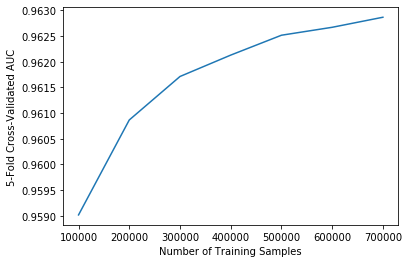

Plot of time to run for GPU Faiss KNN


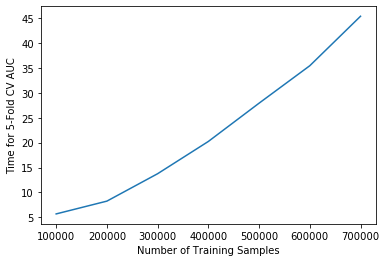

In [11]:

#n_samples_arr = [400000,1000000,1500000,2000000,2500000,3000000,3500000]
n_samples_arr = [50000,100000,150000,200000,250000,300000,350000]
n_samples_arr = np.array(n_samples_arr)
faiss_time_arr = []
auc_score_arr = []
for n_samples in n_samples_arr:

    print(f"Downsampling Dataframes to size: {n_samples} and {n_samples*2}")
    test_subsample_df = test_df.sample(n=n_samples, random_state=1)
    train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

    ####### Separate the label from the normal dataframe

    test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
    test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

    train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
    train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
    #######


    time1 = time.time()
    
    k_val = 25
    # print("Testing dataframes")
    print(f"Starting faiss KNN for k: {k_val}")
    start_time_faiss = time.time()
    
    # faiss_knn = FaissKNeighbors(k=k_val)
    faiss_knn = FaissKNNImpl(k=k_val, faiss=faiss)


    # Start 5 fold cross validation (must be done manually, since estimator is not sklearn formatted)
    skf = StratifiedKFold()
    skf.get_n_splits(train_subsample_df, train_subsample_label_arr)  # Create test indicies and train indicies from the TRAINING data, so that we can validate.
    fold = 1
    accuracy_score_fold_arr = []
    tpr_fold = []
    fpr_fold = []
    auc_fold = []
    for train_index, validate_index in skf.split(train_subsample_df, train_subsample_label_arr):
        X_train, X_validate = train_subsample_df.iloc[train_index], train_subsample_df.iloc[validate_index]  # pull from the train DF to make new train and validate indicies
        y_train, y_validate = np.take(train_subsample_label_arr,train_index), np.take(train_subsample_label_arr,validate_index)   # pull from the train DF to make new train and validate indicies
        
        X_train_cont = np.ascontiguousarray(X_train).astype('float32')
        y_train_cont = np.ascontiguousarray(y_train).astype('float32')
        X_validate_cont = np.ascontiguousarray(X_validate).astype('float32')

        # Get predictions to compare
        faiss_knn.fitModel_GPU(X_train_cont, y_train_cont) #Training the model
        y_pred = faiss_knn.predict_GPU(X_validate_cont)
        # faiss_knn.fit(X_train_cont, y_train_cont) #Training the model
        # y_pred = faiss_knn.predict(X_validate_cont)

        proba = faiss_knn.predict_proba(X_validate_cont)
        proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
        
        auc_score_fold = sklearn.metrics.roc_auc_score(y_true=y_validate, y_score=proba_score)
        # print(auc_score_fold)
        auc_fold.append(auc_score_fold)


        print(f"Fold: {fold} | AUC: {auc_score_fold}")
        fold += 1

    # X_test_cont = np.ascontiguousarray(test_subsample_df).astype('float32')
    # proba = faiss_knn.predict_proba(X_test_cont)
    # print(proba.shape)
    # print(proba[:5])

    # proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
    # y_score_fold.append(proba_score)
    # print(proba_score.shape)


    # #y_score_val = np.mean(y_score_fold, axis=0)
    # y_score_val = np.array(y_score_fold).ravel()
    # print("====================")
    # print(y_score_val.shape)
    # print("AUC:", sklearn.metrics.roc_auc_score(y_true=test_subsample_label_arr, y_score=y_score_val))

    auc_score = np.mean(auc_fold)

    auc_score_arr.append(auc_score)
    faiss_time_arr.append(time.time() - time1)

    print(f"Sample Size: {n_samples*2} | AUC: {auc_score}")

    

#### debug
print(f"Time arr: {faiss_time_arr}")
print(f"Faiss AUC: {auc_score_arr}")

print("Plot of 5 fold CV accuracy between Sklearn KNN vs Faiss KNN")
fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, auc_score_arr)
plt.xlabel('Number of Training Samples')
plt.ylabel('5-Fold Cross-Validated AUC')
ax.set_xticks(n_samples_arr*2)
plt.show()

fig, ax = plt.subplots()
print("Plot of time to run for GPU Faiss KNN")
ax.set_xticks(n_samples_arr)
ax.plot(n_samples_arr*2, faiss_time_arr)
plt.xlabel('Number of Training Samples')
plt.ylabel('Time for 5-Fold CV AUC')
ax.set_xticks(n_samples_arr*2)
plt.show()

In [32]:
k_arr = list(range(2,31))  # (2,31)
faiss_time_arr = []
auc_score_arr = []

for k_val in k_arr:
    # print("Testing dataframes")
    print(f"Starting faiss KNN for k: {k_val}")
    start_time_faiss = time.time()
    
    # faiss_knn = FaissKNeighbors(k=k_val)
    faiss_knn = FaissKNNImpl(k=k_val, faiss=faiss)


    # Start 5 fold cross validation (must be done manually, since estimator is not sklearn formatted)
    skf = StratifiedKFold()
    skf.get_n_splits(train_subsample_df, train_subsample_label_arr)  # Create test indicies and train indicies from the TRAINING data, so that we can validate.
    fold = 1
    accuracy_score_fold_arr = []
    tpr_fold = []
    fpr_fold = []
    auc_fold = []
    for train_index, validate_index in skf.split(train_subsample_df, train_subsample_label_arr):
        X_train, X_validate = train_subsample_df.iloc[train_index], train_subsample_df.iloc[validate_index]  # pull from the train DF to make new train and validate indicies
        y_train, y_validate = np.take(train_subsample_label_arr,train_index), np.take(train_subsample_label_arr,validate_index)   # pull from the train DF to make new train and validate indicies
        
        X_train_cont = np.ascontiguousarray(X_train).astype('float32')
        y_train_cont = np.ascontiguousarray(y_train).astype('float32')
        X_validate_cont = np.ascontiguousarray(X_validate).astype('float32')

        # Get predictions to compare
        faiss_knn.fitModel_GPU(X_train_cont, y_train_cont) #Training the model
        y_pred = faiss_knn.predict_GPU(X_validate_cont)
        # faiss_knn.fit(X_train_cont, y_train_cont) #Training the model
        # y_pred = faiss_knn.predict(X_validate_cont)

        proba = faiss_knn.predict_proba(X_validate_cont)
        proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
        
        auc_score_fold = sklearn.metrics.roc_auc_score(y_true=y_validate, y_score=proba_score)
        # print(auc_score_fold)
        auc_fold.append(auc_score_fold)


        print(f"Fold: {fold} | AUC: {auc_score_fold}")
        fold += 1

    # X_test_cont = np.ascontiguousarray(test_subsample_df).astype('float32')
    # proba = faiss_knn.predict_proba(X_test_cont)
    # print(proba.shape)
    # print(proba[:5])

    # proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
    # y_score_fold.append(proba_score)
    # print(proba_score.shape)


    # #y_score_val = np.mean(y_score_fold, axis=0)
    # y_score_val = np.array(y_score_fold).ravel()
    # print("====================")
    # print(y_score_val.shape)
    # print("AUC:", sklearn.metrics.roc_auc_score(y_true=test_subsample_label_arr, y_score=y_score_val))

    auc_score = np.mean(auc_fold)
    auc_score_arr.append(auc_score)
    print(f"K: {k_val} | AUC: {auc_score}")

    # tpr_val = np.mean(tpr_fold)
    # fpr_val = np.mean(fpr_fold)
    # accuracy_val = np.mean(accuracy_score_fold_arr)
    # print(f"Accuracy Value: {accuracy_val}")
    # faiss_k_scores.append(accuracy_val)

    # end_time_faiss = time.time()

    # faiss_time_arr.append(end_time_faiss - start_time_faiss)

#### debug
print(f"Time arr: {faiss_time_arr}")
print(f"Faiss k scores: {faiss_k_scores}")
print("Plot of 5 fold CV accuracy between Sklearn KNN vs Faiss KNN")

# accuracy_df = pd.DataFrame(columns=["Number of Samples","Sklearn KNN Accuracy","Faiss KNN Accuracy"])
# accuracy_df["Faiss KNN Accuracy"] = faiss_k_scores

# print(accuracy_df)

best_k_idx = np.argmax(np.array(auc_score_arr))
best_k = np.max(np.array(auc_score_arr))

print(f"Best k value: {best_k}, for k: {best_k_idx+1+1}")  # start at 2, instead of 0

fig, ax = plt.subplots()

ax.plot(k_arr, auc_score_arr)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross-Validated AUC')
# ax.set_xticks(k_arr)
plt.show()

# fig, ax = plt.subplots()

# print("Plot of time to run for Sklearn KNN vs Faiss KNN")
# ax.set_xticks(n_samples_arr)
# plt.xlabel('Number of Samples')
# plt.ylabel('Time to Complete 5-Fold CV And Scoring')

# ax.plot(n_samples_arr, faiss_time_arr)
# ax.legend(["Faiss KNN Time"])
# plt.show()

Starting faiss KNN for k: 2


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

Sklearn KNN runtime with cross validation

In [19]:
n_samples = 10000

faiss_k_scores = []  # append with debug vals if needed


print(f"Downsampling Dataframes to size: {n_samples} and {n_samples*2}")
test_subsample_df = test_df.sample(n=n_samples, random_state=1)
train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

####### Separate the label from the normal dataframe

test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
#######


# Start 5 fold cross validation (must be done manually, since estimator is not sklearn formatted)
skf = StratifiedKFold()
skf.get_n_splits(train_subsample_df, train_subsample_label_arr)  # Create test indicies and train indicies from the TRAINING data, so that we can validate.
fold = 1
accuracy_score_fold_arr = []
tpr_fold = []
fpr_fold = []
auc_fold = []

sklearn_knn = KNeighborsClassifier(n_neighbors = 25)  # , n_jobs=-1

for train_index, validate_index in skf.split(train_subsample_df, train_subsample_label_arr):
    X_train, X_validate = train_subsample_df.iloc[train_index], train_subsample_df.iloc[validate_index]  # pull from the train DF to make new train and validate indicies
    y_train, y_validate = np.take(train_subsample_label_arr,train_index), np.take(train_subsample_label_arr,validate_index)   # pull from the train DF to make new train and validate indicies
    
    X_train_cont = np.ascontiguousarray(X_train).astype('float32')
    y_train_cont = np.ascontiguousarray(y_train).astype('float32')
    X_validate_cont = np.ascontiguousarray(X_validate).astype('float32')

    # Get predictions to compare
    sklearn_knn.fit(X_train_cont, y_train_cont) #Training the model
    y_pred = sklearn_knn.predict(X_validate_cont)

    proba = sklearn_knn.predict_proba(X_validate_cont)
    proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
    
    auc_score_fold = sklearn.metrics.roc_auc_score(y_true=y_validate, y_score=proba_score)
    #print(auc_score_fold)
    auc_fold.append(auc_score_fold)

    print(f"Fold: {fold} | AUC: {auc_score_fold}")
    fold += 1

auc_score = np.mean(auc_fold)
print(f"K: {25} | AUC: {auc_score}")

print("Sklearn")
sklearn_knn = KNeighborsClassifier(n_neighbors = 25)  # , n_jobs=-1
# Get predictions to compare
sklearn_knn.fit(train_subsample_df, train_subsample_label_arr) #Training the model
y_pred = sklearn_knn.predict(test_subsample_df)

proba = sklearn_knn.predict_proba(test_subsample_df)
proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)

auc_score_fold = sklearn.metrics.roc_auc_score(y_true=test_subsample_label_arr, y_score=proba_score)
#print(auc_score_fold)
print(f"K: {25} | AUC: {auc_score_fold}")

Downsampling Dataframes to size: 10000 and 20000
Fold: 1 | AUC: 0.9641962881818211
Fold: 2 | AUC: 0.9573985492824919
Fold: 3 | AUC: 0.9542856721394433
Fold: 4 | AUC: 0.9510930385361215
Fold: 5 | AUC: 0.9547409590176804
K: 25 | AUC: 0.9563429014315116
Sklearn
K: 25 | AUC: 0.9548257024802348


non CV k investigation (to save a ton of time)

Fold: 1 | AUC: 0.966344740337808
Fold: 2 | AUC: 0.9660808525894202
Fold: 3 | AUC: 0.9662798081100994
Fold: 4 | AUC: 0.966524188829767
Fold: 5 | AUC: 0.9666362490876486
K: 45 | AUC: 0.9663731677909485
Time arr: [679.5084943771362]
Faiss AUC: [0.9663731677909485]
Fold: 1 | AUC: 0.9665015890214459
Fold: 2 | AUC: 0.9662348566113317
Fold: 3 | AUC: 0.9663857294762255
Fold: 4 | AUC: 0.9666486626212227
Fold: 5 | AUC: 0.966784958073754
K: 50 | AUC: 0.966511159160796
Time arr: [679.5084943771362, 682.1903390884399]
Faiss AUC: [0.9663731677909485, 0.966511159160796]
Fold: 1 | AUC: 0.9665991450110001
Fold: 2 | AUC: 0.9663233613137696
Fold: 3 | AUC: 0.9664923469426765
Fold: 4 | AUC: 0.9667522938640571
Fold: 5 | AUC: 0.9668633340047956
K: 55 | AUC: 0.9666060962272598
Time arr: [679.5084943771362, 682.1903390884399, 686.223947763443]
Faiss AUC: [0.9663731677909485, 0.966511159160796, 0.9666060962272598]
Plot of 5 fold CV accuracy between Sklearn KNN vs Faiss KNN
Best k value: 0.9666060962272598, for 

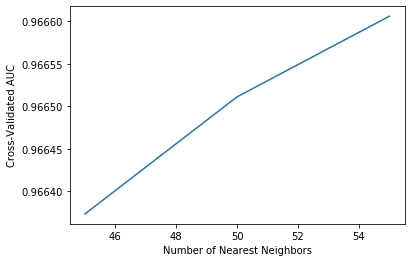

Plot of time to run for GPU Faiss KNN


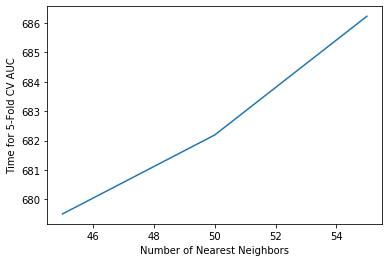

In [8]:
#k_arr = list(range(2,61))  # (2,31)
k_arr = [45, 50, 55]
#faiss_time_arr = [57.45011878013611, 59.61633586883545, 58.51477241516113, 58.854944705963135, 59.02327823638916, 59.43531131744385, 60.85819482803345, 61.42182159423828, 55.459452629089355, 53.581738233566284, 53.38086485862732, 53.433756828308105, 54.72951292991638, 54.20050764083862, 55.07209849357605, 54.24534201622009, 54.416523694992065, 55.22061848640442, 54.71384859085083, 54.681994676589966, 55.24008297920227, 54.42504143714905, 55.121564865112305, 56.88980555534363, 57.96225190162659, 55.90891432762146, 55.745365858078, 56.1034255027771, 56.58453607559204, 57.16475439071655, 55.930387020111084, 55.08576846122742, 56.153494119644165, 56.173667669296265, 56.31771922111511, 56.555033445358276, 56.25402331352234, 55.910898208618164, 56.57630491256714, 56.53018760681152, 57.87349224090576, 55.390838623046875, 55.64422345161438, 55.612128257751465, 56.24703931808472, 55.701292753219604, 55.723792552948, 55.85507273674011, 55.884103536605835, 52.8373601436615, 52.36159324645996, 51.13880491256714, 51.60039281845093, 51.45756459236145, 47.994362115859985, 47.12478494644165, 50.907004833221436, 52.91561532020569, 52.54114890098572]
#auc_score_arr = [0.9197257187371932, 0.9358878353784041, 0.9437663999320008, 0.9484387016484892, 0.9516175011027244, 0.9538125596527463, 0.955488564446153, 0.9567872580104726, 0.9578817540719509, 0.9587244180898302, 0.9593871073599688, 0.9599043525056615, 0.9604238992783237, 0.9608202783206007, 0.9612006024116404, 0.9615215033424613, 0.9618255460088576, 0.9620662892773437, 0.9623061625919604, 0.9624958078792256, 0.9626709122634243, 0.962827626788138, 0.9629542781777543, 0.9631049493847975, 0.9632324964470549, 0.9633199879594148, 0.9634256562842023, 0.9635276263245753, 0.9636082669873234, 0.9636578853422781, 0.9637621898690238, 0.9638302440053774, 0.9639036920838466, 0.9639832511519193, 0.9640516588823257, 0.9641084532277953, 0.9641637846501384, 0.9641964849437425, 0.9642525584448454, 0.9643067737568585, 0.9643573013625911, 0.9644091999382466, 0.9644514581931538, 0.9644855740035941, 0.9645266601793736, 0.964551285856694, 0.9645679920897383, 0.964586707996377, 0.964603731682818, 0.9643949883643808, 0.9644053373885569, 0.9644202303531924, 0.9644461735668184, 0.9644449291172323, 0.9644548824269922, 0.9644678990849267, 0.9644816496001262, 0.964499058484158, 0.9645071130381015]
faiss_time_arr = []
auc_score_arr = []

for k_val in k_arr:
    # if k_val < 61:
    #     continue
    start_time_faiss = time.time()
    
    # faiss_knn = FaissKNeighbors(k=k_val)
    faiss_knn = FaissKNNImpl(k=k_val, faiss=faiss)

    # Start 5 fold cross validation (must be done manually, since estimator is not sklearn formatted)
    skf = StratifiedKFold()
    skf.get_n_splits(train_subsample_df, train_subsample_label_arr)  # Create test indicies and train indicies from the TRAINING data, so that we can validate.
    fold = 1
    accuracy_score_fold_arr = []
    tpr_fold = []
    fpr_fold = []
    auc_fold = []
    for train_index, validate_index in skf.split(train_subsample_df, train_subsample_label_arr):
        X_train, X_validate = train_subsample_df.iloc[train_index], train_subsample_df.iloc[validate_index]  # pull from the train DF to make new train and validate indicies
        y_train, y_validate = np.take(train_subsample_label_arr,train_index), np.take(train_subsample_label_arr,validate_index)   # pull from the train DF to make new train and validate indicies
        
        X_train_cont = np.ascontiguousarray(X_train).astype('float32')
        y_train_cont = np.ascontiguousarray(y_train).astype('float32')
        X_validate_cont = np.ascontiguousarray(X_validate).astype('float32')

        # Get predictions to compare
        faiss_knn.fitModel_GPU(X_train_cont, y_train_cont) #Training the model
        y_pred = faiss_knn.predict_GPU(X_validate_cont)
        # faiss_knn.fit(X_train_cont, y_train_cont) #Training the model
        # y_pred = faiss_knn.predict(X_validate_cont)

        proba = faiss_knn.predict_proba(X_validate_cont)
        proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
        
        auc_score_fold = sklearn.metrics.roc_auc_score(y_true=y_validate, y_score=proba_score)
        # print(auc_score_fold)
        auc_fold.append(auc_score_fold)


        print(f"Fold: {fold} | AUC: {auc_score_fold}")
        fold += 1

    auc_score = np.mean(auc_fold)
    auc_score_arr.append(auc_score)
    print(f"K: {k_val} | AUC: {auc_score}")

    # end_time_faiss = time.time()

    faiss_time_arr.append(time.time() - start_time_faiss)

    #### debug
    print(f"Time arr: {faiss_time_arr}")
    print(f"Faiss AUC: {auc_score_arr}")
print("Plot of 5 fold CV accuracy between Sklearn KNN vs Faiss KNN")

best_k_idx = np.argmax(np.array(auc_score_arr))
best_k = np.max(np.array(auc_score_arr))

print(f"Best k value: {best_k}, for k: {best_k_idx+1+1}")  # start at 2, instead of 0

fig, ax = plt.subplots()

ax.plot(k_arr, auc_score_arr)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross-Validated AUC')
# ax.set_xticks(k_arr)
plt.show()

fig, ax = plt.subplots()
print("Plot of time to run for GPU Faiss KNN")
ax.plot(k_arr, faiss_time_arr)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Time for 5-Fold CV AUC')
plt.show()

In [12]:
k_arr = [55]

for k_val in k_arr:

    start_time_faiss = time.time()

    # faiss_knn = FaissKNeighbors(k=k_val)
    faiss_knn = FaissKNNImpl(k=k_val, faiss=faiss)

    # Start 5 fold cross validation (must be done manually, since estimator is not sklearn formatted)
    skf = StratifiedKFold()
    skf.get_n_splits(train_subsample_df, train_subsample_label_arr)  # Create test indicies and train indicies from the TRAINING data, so that we can validate.
    fold = 1
    accuracy_score_fold_arr = []
    tpr_fold = []
    fpr_fold = []
    auc_fold = []
    for train_index, validate_index in skf.split(train_subsample_df, train_subsample_label_arr):
        X_train, X_validate = train_subsample_df.iloc[train_index], train_subsample_df.iloc[validate_index]  # pull from the train DF to make new train and validate indicies
        y_train, y_validate = np.take(train_subsample_label_arr,train_index), np.take(train_subsample_label_arr,validate_index)   # pull from the train DF to make new train and validate indicies
        
        X_train_cont = np.ascontiguousarray(X_train).astype('float32')
        y_train_cont = np.ascontiguousarray(y_train).astype('float32')
        X_validate_cont = np.ascontiguousarray(X_validate).astype('float32')

        # Get predictions to compare
        faiss_knn.fitModel_GPU(X_train_cont, y_train_cont) #Training the model
        y_pred = faiss_knn.predict_GPU(X_validate_cont)
        # faiss_knn.fit(X_train_cont, y_train_cont) #Training the model
        # y_pred = faiss_knn.predict(X_validate_cont)

        proba = faiss_knn.predict_proba(X_validate_cont)
        proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
        
        auc_score_fold = sklearn.metrics.roc_auc_score(y_true=y_validate, y_score=proba_score)
        # print(auc_score_fold)
        auc_fold.append(auc_score_fold)


        print(f"Fold: {fold} | AUC: {auc_score_fold}")
        fold += 1

    # X_train_cont = np.ascontiguousarray(train_subsample_df).astype('float32')
    # y_train_cont = np.ascontiguousarray(train_subsample_label_arr).astype('float32')
    # X_validate_cont = np.ascontiguousarray(test_subsample_df).astype('float32')
    # y_validate = np.ascontiguousarray(test_subsample_label_arr).astype('float32')

    # faiss_knn.fitModel_GPU(X_train_cont, y_train_cont) #Training the model
    # y_pred = faiss_knn.predict_GPU(X_validate_cont)
    # proba = faiss_knn.predict_proba(X_validate_cont)
    # proba_score = proba[:,1].reshape(proba[:,1].shape[0],1)
    # auc_score = sklearn.metrics.roc_auc_score(y_true=y_validate, y_score=proba_score)

    auc_score = np.mean(auc_fold)
    print(f"K: {k_val} | AUC: {auc_score}")

# end_time_faiss = time.time()

faiss_time_arr.append(time.time() - start_time_faiss)

#### debug
print(f"Time arr: {faiss_time_arr}")
print(f"Faiss AUC: {auc_score_arr}")
print("Plot of 5 fold CV accuracy between Sklearn KNN vs Faiss KNN")

best_k_idx = np.argmax(np.array(auc_score_arr))
best_k = np.max(np.array(auc_score_arr))

print(f"Best k value: {best_k}, for k: {best_k_idx+1+1}")  # start at 2, instead of 0

fig, ax = plt.subplots()

ax.plot(k_arr, auc_score_arr)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross-Validated AUC')
# ax.set_xticks(k_arr)
plt.show()

# fig, ax = plt.subplots()

# print("Plot of time to run for Sklearn KNN vs Faiss KNN")
# ax.set_xticks(n_samples_arr)
# plt.xlabel('Number of Samples')
# plt.ylabel('Time to Complete 5-Fold CV And Scoring')

fig, ax = plt.subplots()
print("Plot of time to run for GPU Faiss KNN")
ax.plot(k_arr, faiss_time_arr)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Time for 5-Fold CV AUC')
plt.show()

Fold: 1 | AUC: 0.9613760283637603
Fold: 2 | AUC: 0.9635983896359839
Fold: 3 | AUC: 0.9615896974039744
Fold: 4 | AUC: 0.9624915111562288
Fold: 5 | AUC: 0.9632894586582237
K: 55 | AUC: 0.9624690170436342


NameError: name 'faiss_time_arr' is not defined